<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY" data-toc-modified-id="IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY</a></span><ul class="toc-item"><li><span><a href="#Air-quality-Data-Exploration-and-Cleanup" data-toc-modified-id="Air-quality-Data-Exploration-and-Cleanup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air quality Data Exploration and Cleanup</a></span><ul class="toc-item"><li><span><a href="#Import-datasets-and-overview-of-the-air-quality-data" data-toc-modified-id="Import-datasets-and-overview-of-the-air-quality-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import datasets and overview of the air quality data</a></span></li><li><span><a href="#Slice-and-dice-the-data-to-clean-up" data-toc-modified-id="Slice-and-dice-the-data-to-clean-up-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Slice and dice the data to clean up</a></span></li><li><span><a href="#Explore-the-data-through-graphs" data-toc-modified-id="Explore-the-data-through-graphs-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Explore the data through graphs</a></span></li></ul></li><li><span><a href="#COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP</a></span></li><li><span><a href="#COVID-19-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-DATA-EXPLORATION-AND-CLEAN-UP-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>COVID-19 DATA EXPLORATION AND CLEAN UP</a></span></li></ul></li></ul></div>

# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Air quality Data Exploration and Cleanup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint

# Import API key
from config import api_key

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

### Import datasets and overview of the air quality data

In [2]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
airdf_2019_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2019_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


### Slice and dice the data to clean up

In [5]:
# Display an overview of the Specie column
airdf_2019_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1'], dtype=object)

In [6]:
airdf_2019_2020["Specie"].value_counts()

temperature      310236
humidity         310145
pressure         308517
pm25             270688
no2              266793
pm10             264859
wind-speed       263292
o3               250438
so2              226576
dew              226147
co               203776
wind-gust        172805
wind speed        47002
wind gust         29576
precipitation     26825
wd                25720
aqi                8267
uvi                5632
pol                3790
pm1                1380
mepaqi              564
neph                440
Name: Specie, dtype: int64

> We understand that "Air movements influence the fate of air pollutants. So any study of air pollution should include a study of the local weather patterns (meteorology). If the air is calm and pollutants cannot disperse, then the concentration of these pollutants will build up. On the other hand, when strong, turbulent winds blow, pollutants disperse quickly, resulting in lower pollutant concentrations." https://www.qld.gov.au/environment/pollution/monitoring/air/air-monitoring/meteorology-influence/meteorology-factors#:~:text=Meteorological%20factors-,Meteorological%20factors,these%20pollutants%20will%20build%20up.
Hence the Meteorology parameters like temperature, humidity, pressure, wind speed, to name a few, should have some sorts of correlations with the air quality.
(http://www.bom.gov.au/vic/observations/melbourne.shtml)

> However, due to the scope of our project, we'll only focus on air pollutant parameters to assess their changes before COVID-19 and 6 months into the pandemic. We're not trying to explain the causes of air quality change. Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**.
https://aqicn.org/publishingdata/

> We'll also remove species with the least number of available data points  including **pol, pm1, mepaqi, neph**.

In [7]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "uvi", "pol", "pm1", "mepaqi", "neph"]

clean_airdf = airdf_2019_2020[~airdf_2019_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [8]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,24/02/2020,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,7/05/2020,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,28/05/2020,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,20/02/2020,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,23/02/2020,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [9]:
clean_airdf["Specie"].value_counts()

pm25    270688
no2     266793
pm10    264859
o3      250438
so2     226576
co      203776
aqi       8267
Name: Specie, dtype: int64

More about AQI:
https://www.airnow.gov/aqi/aqi-basics/
https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
"Five major pollutants:
EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

* Ground-level ozone **o3** (ppm - parts per million)
* Particulate Matter - including PM2.5 **pm25** and PM10 **pm10** (μg/m3)
* Carbon Monoxide **co** (ppm)
* Sulfur Dioxide **so2** (ppb - parts per billion)
* Nitrogen Dioxide **no2** (ppb)

https://en.wikipedia.org/wiki/Air_pollution

"https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/


https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1
https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [10]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491397 entries, 0 to 1491396
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1491397 non-null  object 
 1   Country   1491397 non-null  object 
 2   City      1491397 non-null  object 
 3   Specie    1491397 non-null  object 
 4   count     1491397 non-null  int64  
 5   min       1491397 non-null  float64
 6   max       1491397 non-null  float64
 7   median    1491397 non-null  float64
 8   variance  1491397 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 102.4+ MB


We can see that the Date column is of generic object type. Since we want to perform some time related analysis on this data, we need to convert it to a datetime format. Let’s use to_datetime() function to convert the Date column into a datetime object. 

In [11]:
clean_airdf["Date"] = pd.to_datetime(clean_airdf["Date"], format="%d/%m/%Y")

In [12]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491397 entries, 0 to 1491396
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Date      1491397 non-null  datetime64[ns]
 1   Country   1491397 non-null  object        
 2   City      1491397 non-null  object        
 3   Specie    1491397 non-null  object        
 4   count     1491397 non-null  int64         
 5   min       1491397 non-null  float64       
 6   max       1491397 non-null  float64       
 7   median    1491397 non-null  float64       
 8   variance  1491397 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 102.4+ MB


In [13]:
# Find the earliest date the air quality dataset covers:
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2018-12-31 00:00:00')

In [14]:
# Find the latest date the air quality dataset covers:
clean_airdf["Date"].max()

Timestamp('2020-07-03 00:00:00')

In [15]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'MY', 'NL', 'NZ', 'UG', 'VN',
       'ET', 'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR',
       'IN', 'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [16]:
country_airdata_df = pd.DataFrame(clean_airdf["Country"].unique(), columns=["country_code"])
country_airdata_df

,country_code
0,IR
1,TJ
2,BR
3,CN
4,DK
...,...
90,CW
91,GB
92,NP
93,PT


There are 95 countries in the dataframe, including Australia (AU)....

In [17]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [18]:
clean_airdf["City"].value_counts()

London          5075
Shijiazhuang    3612
Qinhuangdao     3502
Anyang          3482
Beijing         3443
                ... 
Almaty           132
Abidjan          115
Conakry          115
Accra             97
Zamboanga         60
Name: City, Length: 615, dtype: int64

There are 615 cities in our dataframe. Let's see what cities in Australia covered in the dataset.

In [19]:
clean_airdf.loc[clean_airdf["Country"]=="AU", "City"].value_counts()

Sydney        3364
Brisbane      3348
Melbourne     3284
Wollongong    3253
Darwin        3208
Adelaide      3177
Perth         3082
Newcastle     2871
Hobart        1126
Launceston    1126
Canberra      1093
Name: City, dtype: int64

In [20]:
au_cities_list = ["Sydney", "Melbourne", "Perth"]

**Let's explore resampled PM2.5 median values on weekly basis in Melbourne, Victoria**

In [21]:
vic_air_df = clean_airdf.loc[(clean_airdf["Country"] == "AU") & (
    clean_airdf["City"] == "Melbourne")].sort_values("Date").set_index("Date")
vic_air_df

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
2018-12-31,AU,Melbourne,pm10,140,2.0,31.0,18.0,505.25
2018-12-31,AU,Melbourne,so2,33,1.5,2.9,1.5,3.01
2018-12-31,AU,Melbourne,o3,132,7.3,28.1,12.1,332.50
2018-12-31,AU,Melbourne,no2,116,1.0,5.6,2.8,18.30
...,...,...,...,...,...,...,...,...
2020-07-03,AU,Melbourne,pm10,88,3.0,33.0,8.0,314.86
2020-07-03,AU,Melbourne,pm25,118,1.0,45.0,17.0,1002.08
2020-07-03,AU,Melbourne,o3,80,6.4,18.4,12.8,78.87


In [22]:
vic_air_df["Specie"].value_counts()

o3      564
pm10    564
pm25    563
no2     561
co      544
so2     488
Name: Specie, dtype: int64

In [23]:
pm25_vic_air_df = vic_air_df[vic_air_df["Specie"]=="pm25"]
pm25_vic_air_df

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
2019-01-01,AU,Melbourne,pm25,161,1.0,53.0,27.0,1398.93
2019-01-02,AU,Melbourne,pm25,141,9.0,35.0,24.0,405.95
2019-01-03,AU,Melbourne,pm25,183,1.0,54.0,25.0,1325.54
2019-01-04,AU,Melbourne,pm25,192,33.0,60.0,51.0,604.15
...,...,...,...,...,...,...,...,...
2020-06-29,AU,Melbourne,pm25,186,4.0,158.0,60.0,9876.10
2020-06-30,AU,Melbourne,pm25,185,1.0,67.0,25.0,2782.67
2020-07-01,AU,Melbourne,pm25,181,2.0,55.0,19.0,1002.37


In [24]:
weekly_median_pm25_vic_air = pm25_vic_air_df["median"].resample("W").median().rename("pm2.5")
weekly_median_pm25_vic_air

Date
2019-01-06    27.0
2019-01-13    21.0
2019-01-20    38.0
2019-01-27    26.0
2019-02-03    19.0
              ... 
2020-06-07    25.0
2020-06-14    40.0
2020-06-21    20.0
2020-06-28    25.0
2020-07-05    19.0
Freq: W-SUN, Name: pm2.5, Length: 79, dtype: float64

In [25]:
#weekly_median_pm25_vic_air_df = weekly_median_pm25_vic_air.to_frame()
#weekly_median_pm25_vic_air_df.reset_index()

In [26]:
# Set cut-off dates for covid _data
cut_off_date = weekly_median_pm25_vic_air.tail(1).index[0]
cut_off_date

Timestamp('2020-07-05 00:00:00', freq='W-SUN')

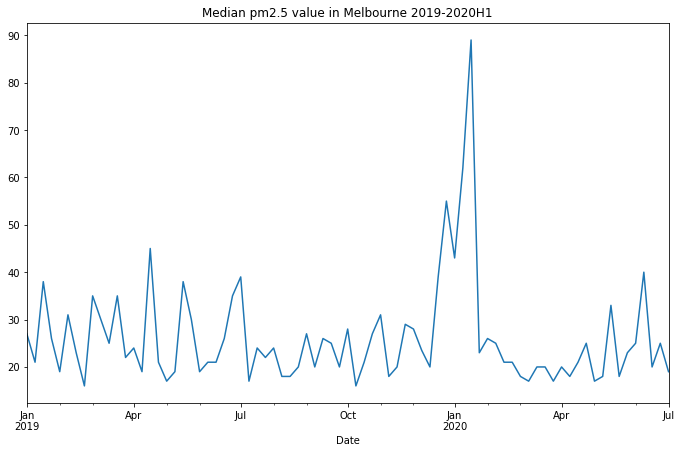

In [27]:
weekly_median_pm25_vic_air.plot(figsize=(11.5, 7), title="Median pm2.5 value in Melbourne 2019-2020H1")

In [28]:
rolling_median_pm25_vic_air = pm25_vic_air_df["median"].rolling(30, center=True).mean()

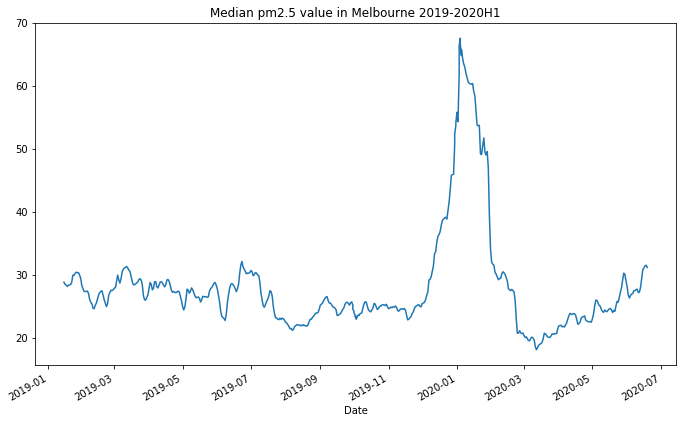

In [29]:
rolling_median_pm25_vic_air.plot(figsize=(11.5, 7), title="Median pm2.5 value in Melbourne 2019-2020H1")

**"Unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series."** (https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

In [31]:
au_air_df = clean_airdf.loc[clean_airdf["Country"]=="AU"]
au_air_df

,Date,Country,City,Specie,count,min,max,median,variance
171565,2020-02-04,AU,Sydney,co,56,1.2,4.5,3.4,10.12
171566,2020-03-29,AU,Sydney,co,9,1.2,3.4,2.3,9.07
171567,2020-06-26,AU,Sydney,co,45,1.2,6.7,2.3,17.91
171568,2020-05-22,AU,Sydney,co,14,1.2,2.3,1.2,2.19
171569,2020-06-04,AU,Sydney,co,33,1.2,5.6,2.3,16.16
...,...,...,...,...,...,...,...,...,...
1284748,2019-12-21,AU,Wollongong,pm10,72,28.0,57.0,35.0,1107.82
1284749,2019-10-11,AU,Wollongong,pm10,65,7.0,14.0,10.0,35.66
1284750,2019-11-24,AU,Wollongong,pm10,72,12.0,31.0,18.0,236.60
1284751,2019-12-16,AU,Wollongong,pm10,48,29.0,44.0,39.0,192.61


In [32]:
five_cities_au_pm25_df = au_air_df[(au_air_df["City"].isin(au_cities_list)) & (
    au_air_df["Specie"] == "pm25")].sort_values("Date").copy()
five_cities_au_pm25_df

,Date,Country,City,Specie,count,min,max,median,variance
653866,2018-12-31,AU,Sydney,pm25,168,47.0,63.0,55.0,106.59
655757,2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
657659,2018-12-31,AU,Perth,pm25,54,33.0,44.0,37.0,68.04
653858,2019-01-01,AU,Sydney,pm25,166,37.0,69.0,56.0,546.53
655764,2019-01-01,AU,Melbourne,pm25,161,1.0,53.0,27.0,1398.93
...,...,...,...,...,...,...,...,...,...
176342,2020-07-02,AU,Melbourne,pm25,158,1.0,46.0,18.0,858.35
180172,2020-07-02,AU,Perth,pm25,81,18.0,48.0,31.0,671.00
180251,2020-07-03,AU,Perth,pm25,59,11.0,35.0,20.0,362.33
172488,2020-07-03,AU,Sydney,pm25,107,1.0,61.0,22.0,1286.52


In [33]:
five_cities_au_pm25_transposed_df = five_cities_au_pm25_df.pivot_table(index="Date", columns="City", values="median")
five_cities_au_pm25_transposed_df.head(20)

City,Melbourne,Perth,Sydney
Date,,,
2018-12-31,28.0,37.0,55.0
2019-01-01,27.0,30.0,56.0
2019-01-02,24.0,35.0,50.0
2019-01-03,25.0,25.0,45.0
2019-01-04,51.0,27.0,30.0
2019-01-05,37.0,24.0,45.0
2019-01-06,19.0,29.0,38.0
2019-01-07,13.0,41.0,27.0
2019-01-08,26.0,33.0,26.0


In [34]:
five_cities_au_pm25_transposed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 551 entries, 2018-12-31 to 2020-07-03
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Melbourne  549 non-null    float64
 1   Perth      532 non-null    float64
 2   Sydney     549 non-null    float64
dtypes: float64(3)
memory usage: 17.2 KB


In [35]:
resampled_five_cities_au_pm25_transposed_df = five_cities_au_pm25_transposed_df[au_cities_list].resample("W").median()
resampled_five_cities_au_pm25_transposed_df

City,Sydney,Melbourne,Perth
Date,,,
2019-01-06,45.0,27.0,29.0
2019-01-13,27.0,21.0,38.0
2019-01-20,41.0,38.0,34.0
2019-01-27,47.0,26.0,24.0
2019-02-03,34.0,19.0,35.0
...,...,...,...
2020-06-07,17.0,25.0,34.5
2020-06-14,22.0,40.0,27.0
2020-06-21,21.0,20.0,30.0


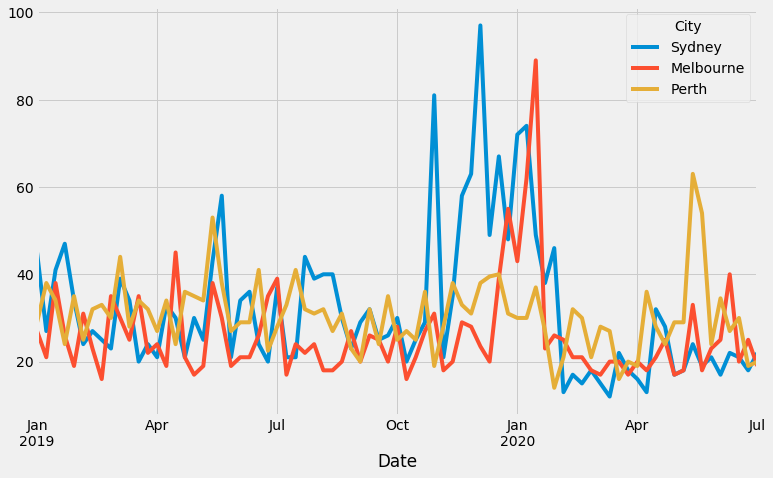

In [36]:
plt.style.use('fivethirtyeight')
resampled_five_cities_au_pm25_transposed_df.plot(figsize=(11.5, 7))

In [37]:
rolling_five_cities_au_pm25 = five_cities_au_pm25_transposed_df[au_cities_list].rolling(7, center=True).mean()

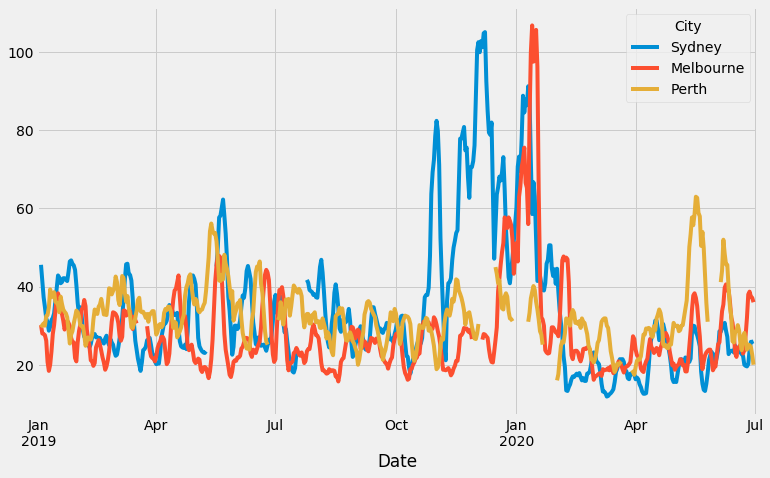

In [38]:
plt.style.use('fivethirtyeight')
rolling_five_cities_au_pm25.plot(figsize=(11.5, 7))

### Explore the data through graphs

In [ ]:
unique_species = clean_airdf["Specie"].unique()
unique_species

In [ ]:
def specie_median_distribution(df, country):

    country_air_df = df[df["Country"] == country]

    fig, ax = plt.subplots(
        figsize=(10, 3*len(unique_species)),
        ncols=1,
        nrows=len(unique_species)
        )

    for index, specie in enumerate(unique_species):
        red_square=dict(markerfacecolor='r', marker='s', alpha=0.4)

        country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
au_air_df = clean_airdf[clean_airdf["Country"]==]

In [ ]:
        ax[index].set_title=f"Distribution of median {specie} values in {country} (2019-2020H1)"

In [ ]:
specie_median_distribution(clean_airdf, "AU")

In [ ]:
variance_0_df = clean_airdf[cleanclean_airdf["variance"]==0]
variance_0_df

In [ ]:
clean_airdf[clean_airdf["Specie"]=="pm25"]

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm25") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "no2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="no2") & (clean_airdf["median"]>=150)]

In [ ]:
specie_median_distribution(clean_airdf, "pm10")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm10") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "o3")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="o3") & (clean_airdf["median"]>=350)]

In [ ]:
specie_median_distribution(clean_airdf, "so2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="so2") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "co")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="co") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "aqi")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="aqi") & (clean_airdf["median"]>=350)]

In [ ]:
variance_0_df["Country"].unique()

## COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP

In [ ]:
au_covid_url = "https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json"
au_covid_data = requests.get(au_covid_url).json()
pprint(au_covid_data)

In [ ]:
au_covid_data.keys()

In [ ]:
au_covid_data['sheets'].keys()

In [ ]:
covid_by_state = au_covid_data['sheets']['updates']
covid_by_state[50]

In [ ]:
state_list = list()
date_list = list()
cumulative_case_count = list()
cumulative_recovered_count = list()

for element in covid_by_state:
    state_list.append(element["State"])
    date_list.append(element["Date"])
    cumulative_case_count.append(element["Cumulative case count"])
    cumulative_recovered_count.append(element["Recovered (cumulative)"])

In [ ]:
au_covid_df = pd.DataFrame({
    "State": state_list,
    "Date": date_list,
    "Cumulative case count": cumulative_case_count,
    "Cumulative recovered count": cumulative_recovered_count
})
au_covid_df.head()

In [ ]:
au_covid_df.info()

In [ ]:
au_covid_df["Cumulative case count"] = pd.to_numeric(au_covid_df["Cumulative case count"].str.replace(",", ""))

In [ ]:
au_covid_df["Cumulative recovered count"] = pd.to_numeric(au_covid_df["Cumulative recovered count"].str.replace(",", ""))

In [ ]:
# Convert the Date column to datetime format
au_covid_df['Date'] = pd.to_datetime(au_covid_df["Date"], format= "%d/%m/%Y", errors='coerce')

In [ ]:
au_covid_df.info()

In [ ]:
# Find the earliest date the covid dataset covers:
au_covid_df["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
au_covid_df["Date"].max()

In [ ]:
# Set cutoff time on 5th July 2020 for the AU covid data
timebound_au_covid =  au_covid_df[au_covid_df["Date"] <= cut_off_date[0]].copy()

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid.sort_values(["State", "Date"], inplace=True, ignore_index=True)
timebound_au_covid

In [ ]:
cols_to_fill = ["Cumulative case count", "Cumulative recovered count"]

timebound_au_covid[cols_to_fill]= timebound_au_covid.groupby("State")[cols_to_fill].fillna(method="ffill")

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid.fillna(0, inplace=True)

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid[cols_to_fill] = timebound_au_covid[cols_to_fill].astype(int)

In [ ]:
timebound_au_covid.info()

In [ ]:
clean_au_covid = timebound_au_covid.copy()

In [ ]:
clean_au_covid.tail(20)

In [ ]:
clean_au_covid["Active_cases"] = clean_au_covid["Cumulative case count"] - clean_au_covid["Cumulative recovered count"]

In [ ]:
clean_au_covid

In [ ]:
clean_au_covid['New case count'] = clean_au_covid.groupby(['State'])['Cumulative case count'].diff().fillna(0).astype(int)

In [ ]:
clean_au_covid

In [ ]:
vic_covid = clean_au_covid[clean_au_covid["State"]=="VIC"].set_index("Date")
vic_covid

In [ ]:
ax = vic_covid.plot(y="Active_cases", figsize=(15, 8), title="Number of active Covid-19 cases in Victoria 2020H1")
ax.set_ylabel("Number of active cases")
ax.set_xlabel("Year-Month")

In [ ]:
weekly_active_cases_vic_covid = vic_covid["Active_cases"].resample("W").sum().to_frame()
weekly_active_cases_vic_covid

In [ ]:
# Fill in dates to 
date_range_to_fill = pd.date_range(starting_date, "2020-01-19", freq="W").to_frame(name="Active_cases")
date_range_to_fill["Active_cases"]=0
date_range_to_fill

In [ ]:
time_matching_vic_covid_weekly_cases_df = pd.concat(
    [date_range_to_fill, weekly_active_cases_vic_covid]).reset_index().rename(columns={"index": "Date"})
time_matching_vic_covid_weekly_cases_df

In [ ]:
weekly_median_pm25_vic_air_df.reset_index(inplace=True)
weekly_median_pm25_vic_air_df

In [ ]:
ax = weekly_median_pm25_vic_air_df.plot(x="Date", y="pm2.5", linestyle="-", marker="o")
time_matching_vic_covid_weekly_cases_df.plot(kind="bar", x="Date", y="Active_cases", ax=ax)

## COVID-19 DATA EXPLORATION AND CLEAN UP

Covid-19 is sourced from here https://covid19api.com/

In [ ]:
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

In [ ]:
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

In [ ]:
# Merge countries available on the air quality data and the covid data
country_covid_air_df = pd.merge(
    country_airdata_df, country_covid_df, how="left", left_on="country_code", right_on="ISO2")
country_covid_air_df

In [ ]:
# Find the country in the country_airdata_df but not country_covid_df
country_to_remove = country_covid_air_df[country_covid_air_df["ISO2"].isna()]["country_code"].tolist()
country_to_remove

In [ ]:
final_airdf = clean_airdf[~clean_airdf["Country"].isin(country_to_remove)].copy()

In [ ]:
final_airdf["Country"].nunique()

In [ ]:
country_covid_air_df

In [ ]:
del country_covid_air_df["ISO2"]

In [ ]:
# Return a dataframe covering all countries in both the air quality data and covid-19 data.
country_covid_air_df = country_covid_air_df[~country_covid_air_df["country_code"].isin(
    country_to_remove)].reset_index()
country_covid_air_df

In [ ]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

The above api example covers covid-19 data until 4th July 2020. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through our country_covid_air_df as above.

In [ ]:
slug_list = country_covid_air_df["Slug"].tolist()
len(slug_list)

In [ ]:
base_covid_url = "https://api.covid19api.com/total/country/"
    
country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:
    
    try:
        response = requests.get(base_covid_url + slug).json()
    
        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

In [ ]:
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

In [ ]:
covid_df.info()

In [ ]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [ ]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
covid_df["Date"].max()

In [ ]:
# Set cutoff date to the latest date on the air quality data
world_covid_df = covid_df[covid_df["Date"] <= cut_off_date]

In [ ]:
world_covid_df.info()

In [ ]:
world_covid_df.tail()

In [ ]:
# import time
# from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

In [ ]:
# url = "https://api.openaq.org/v1/measurements"

# data = requests.get(url).json()
# pprint(data)

In [ ]:
# len(data["results"])

In [ ]:
# data["results"][0]

In [ ]:
# Data source: https://aqicn.org/api/
# base_url = "https://api.waqi.info/feed/"
# city = "melbourne"
# url = f"{base_url}{city}/?token={api_key}"

In [ ]:
# url_2 = "https://api.covid19api.com/country/south-africa/status/confirmed/live"
# covid_data_2 = requests.get(url_2).json()
# pprint(covid_data_2[-1])